# 0. Installation and Usage

## 0.1 External Installations

In [5]:
%%bash
pip install -q gdown
pip install -q torch
pip install -q pytorch-lightning
pip install -q ultralytics
pip install -q ftfy regex tqdm
pip install -q git+https://github.com/openai/CLIP.git
pip install -q transformers==4.29
pip install -q sentencepiece==0.1.97


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


## 0.2 Data

In [6]:
%config NotebookApp.iopub_data_rate_limit=10000000

In [7]:
# Download dataset from Google Drive
!gdown 1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x

Downloading...
From (uriginal): https://drive.google.com/uc?id=1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x
From (redirected): https://drive.google.com/uc?id=1tkTUpbdkPqQ1JgHcVlsT0ikjcftF4P6x&confirm=t&uuid=79c00419-639f-45d9-80b6-7dfd97c541fa
To: /home/matea/Documents/VisualGrounding/DeepLearning/Code/refcocog.tar.zip
100%|██████████████████████████████████████| 13.5G/13.5G [21:05<00:00, 10.6MB/s]


In [8]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
#Move the file from the local pc to the drive

#!mv refcocog.tar.zip "/content/drive/My Drive/RefCOCOg/"

In [ ]:
%%bash


#unzip "/content/drive/My Drive/RefCOCOg/refcocog.tar.zip" -d "/content/drive/My Drive/RefCOCOg/"
#rm "/content/drive/My Drive/RefCOCOg/refcocog.tar.zip"

# Un-tar dataset and then remove tar file

tar -xvf "/content/drive/My Drive/RefCOCOg/refcocog.tar" -C "/content/drive/My Drive/RefCOCOg/"
rm "/content/drive/My Drive/RefCOCOg/refcocog.tar"

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 0.3 Imports

In [ ]:
import os
import numpy as np
import pandas as pd
import pprint

import pickle
from typing import Any, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchmetrics


import pytorch_lightning as pl
from pytorch_lightning.utilities.types import STEP_OUTPUT

from transformers import T5Tokenizer, T5ForConditionalGeneration

from tqdm import tqdm

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import clip
from ultralytics import YOLO

/home/matea/Documents/VisualGrounding/DeepLearning/DeepBlasphemy/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. Dataset

### 1.1 Dataset Class

In [ ]:
from torch.utils.data import Dataset

import json

class RefCOCOg(Dataset):
    """
    Args:
        dataset: a list of dictionaries containing:
        {
            'file_name': # path of the image, images will be loaded on the fly
            'caption': # referring caption
            'ann_id': # annotation ID (one per caption), taken from 'file_name'
            'bbox': # coordinates (xmin, ymin, xmax, ymax) of the bounding box
        }
    """
    def __init__(self, refs, annotations, split="train"):

        self.dataset = [{"file_name": os.path.join("./refcocog/images/", f'{"_".join(elem["file_name"].split("_")[:3])}.jpg'),
                            "caption": elem["sentences"][0]["raw"],
                            "ann_id": int(elem["file_name"].split("_")[3][:-4]),
                            "bbox": annotations[int(elem["file_name"].split("_")[3][:-4])]}
                        for elem in [d for d in refs if d["split"]==split]]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

    def __call__(self, idx):
        print(json.dumps(self.dataset[idx], indent=4))

### 1.2 Load Refs and Annotations

In [ ]:
# Load refs and annotations
import pickle

with open("./refcocog/annotations/refs(umd).p", "rb") as fp:
  refs = pickle.load(fp)

# 'annotations' will be a dict object mapping the 'annotation_id' to the 'bbox' to make search faster
with open("./refcocog/annotations/instances.json", "rb") as fp:
  data = json.load(fp)
  annotations = dict(sorted({ann["id"]: ann["bbox"] for ann in data["annotations"]}.items()))

### 1.3 DataLoader

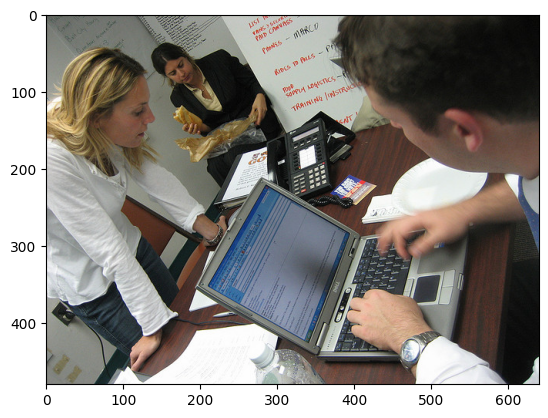

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np
import os

from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image, ImageDraw

def pad_image(image):
    """
    Performs bottom-right padding of the original image to 640x640 (max size of images in the dataset).
    Bottom-right padding prevents corruption of bounding boxes.

    ### Arguments
    image: a PIL.Image to transform
    """
    original_width, original_height = image.size
    padded_width, padded_height = 640, 640

    pad_width = padded_width - original_width
    pad_height = padded_height - original_height

    padded_image = Image.new(image.mode, (padded_width, padded_height), (0, 0, 0))
    padded_image.paste(image, (0, 0))

    return padded_image

def collate_fn(batch):
    images = []
    for sample in batch:
        image = Image.open(sample["file_name"]).convert("RGB")
        image = pad_image(image=image)
        images.append(transform(image))
    images = torch.stack(images, dim=0) #Concatenates a sequence of tensors along a new dimension.

    data = {}
    for key in batch[0].keys():
        if key != "file_name":
            data[key] = [sample[key] for sample in batch]

    print(data)
    print("--------------------------")

    return images, data

transform = transforms.Compose([
    transforms.Resize(244),
    transforms.CenterCrop(244),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
])

# create dataset and dataloader
dataset = RefCOCOg(refs, annotations, split="train")
plt.imshow(Image.open(dataset[0]["file_name"]))
dataloader = DataLoader(dataset, batch_size=1, collate_fn=collate_fn)


### Usage:

# for d in dataloader:

#     img = np.array(d[0][0].cpu().numpy().transpose(1, 2, 0)*255, dtype=np.uint8)
#     bbox = d[1]["bbox"][0]
#     img = Image.fromarray(img)
#     draw = ImageDraw.Draw(img)
#     draw.rectangle(((bbox[0], bbox[1]), (bbox[2]+bbox[0], bbox[3]+bbox[1])), width=3)

#     plt.imshow(img)
#     plt.show()
#     break

Explanation of the code

1. **pad_image(image) Function**:
* This function takes an input PIL.Image and performs bottom-right padding to resize the image to a maximum size of 640x640. The purpose of this padding is to ensure that the bounding boxes in the dataset are not corrupted during transformations.
* It calculates the original width and height of the input image.
* Calculates the padding required for both width and height to reach the desired size (640x640).
* Creates a new PIL.Image with the specified padded dimensions and fills it with black color (0, 0, 0).
Overlays the original image onto the padded image at the top-left corner.
* Returns the padded image.
2. **collate_fn(batch) Function**:
* This function is used as a collate function for the DataLoader, which means it defines how to process a batch of samples before feeding them into the neural network.
* It takes a batch of samples, where each sample is a dictionary containing a "file_name" key (indicating the image file path) and other keys for different annotations or labels.
* For each sample in the batch:
  * It opens the image using the "file_name" key, converts it to the RGB mode, and then pads the image using the pad_image function.
  * The transformed image is then passed through the specified transform (in this case, a ToTensor transformation) to convert it into a PyTorch tensor.
* The transformed images are stacked along a new dimension (batch dimension) using torch.stack to form a batch of image tensors.
* The data dictionary is constructed to gather all other keys from the batch of samples except for the "file_name" key.
* The constructed data dictionary and the batch of transformed images are returned.
  
3. **transform Definition**:
* A PyTorch transformation composed of a single transformation step, transforms.ToTensor(), which converts the image to a PyTorch tensor.

4. **Dataset and DataLoader Setup**:
* A dataset named RefCOCOg is created using the provided refs, annotations, and split="train". This is likely a custom dataset class designed for a specific task.
* An example image from the dataset is opened using Image.open and displayed using plt.imshow.
* A DataLoader named dataloader is created using the dataset with a batch size of 1 and the previously defined collate_fn for processing batches.


In [ ]:
iter_loader = iter(dataloader)
batch1 = next(iter_loader)
#pprint(batch1)

{'caption': ['Two woman one in black eatting and the other has a white shirt at the desk'], 'ann_id': [1241542], 'bbox': [[0.0, 45.95, 238.92, 408.64]]}
--------------------------


### Utils

In [ ]:
import torch
import clip
from PIL import Image, ImageDraw
import cv2
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
def load_image_plt(path):
    """ Load image with matplotlib"""
    return plt.imread(path)

def load_image_pil(path):
    """ Load image with PIL"""
    return Image.open(path)

def get_distance_box_iou_accuracy(box_pred, box_true, iou_threshold=0.5):
    """
    Given the target boxes and the prediction return the
    accuracy of the prediction. The accuracy is computed as
    the percentage of boxes that have an IoU > iou_threshold
    with the target box.

    Args:
    @params box_pred: tensor of shape (batch_size, n_boxes, 4)
    @params box_true: tensor of shape (batch_size, n_boxes, 4)
    @params iou_threshold: float

    Returns:
    @params accuracy: float

    """

    iou = torchvision.ops.box_iou(box_pred, box_true).diagonal()
    giou = torchvision.ops.generalized_box_iou(box_pred, box_true).diagonal()

    return (iou > iou_threshold).float().mean(), iou.mean(), giou.mean()

This function, **get_distance_box_iou_accuracy**, is designed to compute various accuracy metrics based on **Intersection over Union (IoU)** calculations for bounding boxes. It takes predicted bounding boxes and ground truth bounding boxes as inputs and returns three metrics: accuracy, IoU mean, and Generalized IoU mean. Here's what each part of the function does:




*   **box_pred**: This is a tensor containing predicted bounding boxes for a batch of images. It has a shape of **(batch_size, n_boxes, 4)**, where **batch_size** is the number of images in the batch, **n_boxes** is the number of boxes per image, and the last dimension represents the coordinates of each box **(x_min, y_min, x_max, y_max)**.
*   **box_true**: This is a tensor containing ground truth bounding boxes for the same batch of images. It has the same shape as **box_pred** and represents the correct bounding box coordinates for evaluation.
* **iou_threshold**: This is a floating-point value representing the IoU threshold used to determine whether a predicted box is considered accurate. If the IoU between a predicted box and a ground truth box is greater than this threshold, the predicted box is considered accurate.
* **iou**: The Intersection over Union (IoU) is calculated using **torchvision.ops.box_iou**, which computes the IoU between predicted and ground truth bounding boxes. The **.diagonal()** operation extracts the diagonal elements from the resulting IoU tensor. These diagonal elements represent the IoU between each predicted box and its corresponding ground truth box.
* **giou**: The Generalized Intersection over Union (GIoU) is calculated using **torchvision.ops.generalized_box_iou**, which computes the GIoU between predicted and ground truth bounding boxes. The **.diagonal()** operation extracts the diagonal elements from the resulting GIoU tensor.
* **accuracy**: This metric is calculated by comparing the IoU values to the **iou_threshold**. The number of predicted boxes with IoU values greater than the threshold is calculated using **(iou > iou_threshold)**. The **.float().mean()** operation computes the mean accuracy over all predicted boxes in the batch.
* **iou.mean()**: This returns the mean IoU over all predicted boxes in the batch.
* **giou.mean()**: This returns the mean GIoU over all predicted boxes in the batch.


## CLIP Module

In [ ]:
resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained=True)
utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_convnets_processing_utils')

resnet50.eval().to(device)


Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /home/matea/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layers): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d

In [ ]:
class CLIP(nn.Module):
    def __init__(self,image_encode, text_encode, use_allgather):
        super().__init__()
        self.use_allgather = use_allgather
        self.visual = resnet50
        self.encode_text = text_encode
        self.logit_scale = nn.Parameter(torch.ones([1]))
        # self.logit_scale = nn.Parameter(torch.ones([]))
        nn.init.constant_(self.logit_scale, np.log(1/0.07))
        #nn.init.normal_(self.text_projection, std=self.transformer.width ** -0.5)
        
    def visual_parameters(self):
        return []

    def visual_modules(self):
        return [self.visual]
    
    def encode_image(self, image):
        return self.visual(image.type(self.dtype))

    def sample_captions(self, texts):
        return [text[0] for text in texts]

    def forward(self, input, all_gather=False):
        # input
        images = input['images']
        texts = input['captions']
        texts = self.sample_captions(texts)
        # text&image encode 
        image_features = resnet50(images)
        text_features = self.encode_text(texts)


        # normalized features
        image_features = image_features / (image_features.norm(dim=-1, keepdim=True))
        text_features = text_features / (text_features.norm(dim=-1, keepdim=True)+1e-10)

        # cosine similarity as logits
        logit_scale = self.logit_scale.exp()
        logit_scale.data = torch.clamp(logit_scale.data, max=100)

        logits_per_image = logit_scale * image_features @ text_features.t()
        logits_per_text = logit_scale * text_features @ image_features.t()

        return logits_per_image, logits_per_text


In [ ]:
class EMA_logit_scale():
    def __init__(self, param, threshold):
        self.param = param
        self.buffer = 3.125
        self.momentum = 0.9
        self.threshold = threshold
        self.clip_number = 0

    def update(self):
        self.buffer = self.momentum*self.buffer + \
            (1-self.momentum)*self.param.data

    def clamp(self):
        if (self.param-self.buffer) > self.threshold:
            self.param.data = torch.as_tensor(
                self.buffer+self.threshold, dtype=self.param.dtype, device=self.param.device)
            self.clip_number += 1
        elif (self.buffer-self.param) > self.threshold:
            self.param.data = torch.as_tensor(
                self.buffer-self.threshold, dtype=self.param.dtype, device=self.param.device)
            self.clip_number += 1
        # self.param.data = torch.as_tensor(
        #     3.125, dtype=self.param.dtype, device=self.param.device)

In [ ]:
from torch.nn.modules.loss import _Loss

class ClipInfoCELoss(_Loss):
    # def __init__(self, partition_num):
    def __init__(self):
        super(ClipInfoCELoss, self).__init__()
        # self.partition_num = partition_num

    # def forward(self, logits_per_image, logits_per_text, batch):
    #def forward(self, logits):
    #    labels = torch.arange(len(logits)).cuda()
    #    loss_i = F.cross_entropy(logits, labels)
    #    loss_t = F.cross_entropy(logits.t(), labels)
    #    loss = (loss_i+loss_t)/2
    #    return loss
    def forward(self, logits_per_image, logits_per_text):
        bs, l_bs = logits_per_image.shape
        #if l_bs == bs:
        labels = torch.arange(len(logits_per_image)).cuda()
        #else:
        #    labels = link.get_rank() * bs + torch.arange(0, bs, dtype=torch.long).cuda()

        loss_i = F.cross_entropy(logits_per_image, labels)
        loss_t = F.cross_entropy(logits_per_text, labels)
        loss = (loss_i+loss_t)/2
        return loss, labels
    
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res



grad_clip:
    type: logit_scale_param_value
    value: 3
    max_value: 6


In [4]:
grad_clip = {}
grad_clip['type'] = 'logit_scale_param_value'
grad_clip['max_value'] = 6
grad_clip['value'] = 3

In [ ]:
import time

def train(self, optimizer):
    self.criterion = ClipInfoCELoss()
    self.optimizer = optimizer
    last_logit_scale = 0
    total_step = len(self.train_data['loader'])
    start_step = self.state['last_iter'] + 1
    end = time.time()
    logit_scale = EMA_logit_scale(self.logit_scale,
                    grad_clip['value'])
    train_loss = 1e9
    for i in range(len(self.train_data['loader'])):
            
            if self.prefetch:
                batch = self.prefetcher.next()
            else:
                batch = next(self.train_data['loader'])
        # for i, batch in enumerate(self.train_data['loader']):
            # images = batch['images']
            # texts = [caption[0] fro caption in batch['captions']] # use first caption of each image
            curr_step = start_step + i
            self.lr_scheduler.step(curr_step)
            # lr_scheduler.get_lr()[0] is the main lr
            current_lr = self.lr_scheduler.get_lr()[0]
            # measure data loading time
            self.meters.data_time.update(time.time() - end)
            # transfer input to gpu
            # target = target.squeeze().cuda().long()
            batch['images'] = batch['images'].cuda()
            # batch.cuda()
            # mixup
            # if self.mixup < 1.0:
            #     batch, target_a, target_b, lam = mixup_data(
            #         batch, target, self.mixup)
            # cutmix
            # if self.cutmix > 0.0:
            #     input, target_a, target_b, lam = cutmix_data(
            #         input, target, self.cutmix)
            # forward
            logits_per_image, logits_per_text = self.model(batch)
            # loss
            #loss = self.criterion(logits_per_image) / self.dist.world_size
            #target = torch.arange(len(logits_per_image)).cuda().long()
            loss, target = self.criterion(logits_per_image, logits_per_text)

            # measure accuracy and record loss
            prec1, prec5 = accuracy(
                logits_per_image, target, topk=(1, self.topk))

            reduced_loss = loss.clone()
            #reduced_prec1 = prec1.clone() / self.dist.world_size
            #reduced_prec5 = prec5.clone() / self.dist.world_size

            #self.meters.losses.reduce_update(reduced_loss)
            #self.meters.top1.reduce_update(reduced_prec1)
            #self.meters.top5.reduce_update(reduced_prec5)

            # auto resume
            if curr_step % 50 == 0:
                self.logger.info(f'Iter[{curr_step}]: self.meters.losses.avg:{self.meters.losses.avg:.5f},  current_lr:{current_lr},  previous_loss:{train_loss:.5f}')

            resume = False
            if curr_step > 100 and self.meters.losses.avg > train_loss + 0.5:
                resume = True
                self.logger.info(f'[ERROR] Training Loss Crashed,lr:{current_lr},prec1:{prec1},curr_step:{curr_step}, meters.losses.avg:{self.meters.losses.avg}')
            else:
                train_loss = self.meters.losses.avg

            # compute and update gradient
            self.optimizer.zero_grad()

            def param_clip_before():
                self.logit_scale.data.clamp_(min=grad_clip['value'], 
                                                              max=grad_clip['max_value'])
            def param_clip_after():
                self.logit_scale.data.clamp_(min=grad_clip['value'], 
                                                              max=grad_clip['max_value'])

            param_clip_before()
            
            loss.backward()
            self.model.sync_gradients()
            if self.config.get('check_grad', False):
                self.check_model_and_grad(10)
            self.optimizer.step()

            param_clip_after()

            # measure elapsed time
            self.meters.batch_time.update(time.time() - end)
            """    
            # testing during training
            if curr_step > 0 and curr_step % self.config.saver.val_freq == 0:
                for id, val_data in enumerate(self.val_data):
                    metrics = self.evaluate(val_data)
                    if self.ema is not None:
                        self.ema.load_ema(self.model)
                        ema_metrics = self.evaluate(val_data)
                        self.ema.recover(self.model)
                        if self.dist.rank == 0 and self.config.data.test[id].test.evaluator.type == 'imagenet':
                            metric_key = 'top{}'.format(self.topk)
                            self.tb_logger.add_scalars(
                                'dataset_{}_acc1_val'.format(id), {'ema': ema_metrics.metric['top1']}, curr_step)
                            self.tb_logger.add_scalars(
                                'dataset_{}_acc5_val'.format(id), {'ema': ema_metrics.metric[metric_key]}, curr_step)

                    # testing logger
                    if self.dist.rank == 0 and self.config.data.test[id].test.evaluator.type == 'imagenet':
                        metric_key = 'top{}'.format(self.topk)
                        self.tb_logger.add_scalar(
                            'dataset_{}_acc1_val'.format(id), metrics.metric['top1'], curr_step)
                        self.tb_logger.add_scalar(
                            'dataset_{}_acc5_val'.format(id), metrics.metric[metric_key], curr_step)
            
            if curr_step > 0 and curr_step % self.config.saver.save_freq == 0:
                # save ckpt
                if self.dist.rank == 0:
                    if self.config.saver.save_many:
                        ckpt_name = f'{self.path.save_path}/ckpt_{curr_step}.pth.tar'
                    else:
                        ckpt_name = f'{self.path.save_path}/ckpt.pth.tar'
                    self.state['model'] = self.model.state_dict()
                    self.state['optimizer'] = self.optimizer.state_dict()
                    self.state['last_iter'] = curr_step
                    if self.ema is not None:
                        self.state['ema'] = self.ema.state_dict()
                    torch.save(self.state, ckpt_name)
                    if curr_step % (self.config.saver.save_freq*10) == 0:
                        print('save model kth')
                        k_times_save_path = f'{self.path.save_path}_k_times'
                        if not os.path.exists(k_times_save_path):
                            os.makedirs(k_times_save_path)
                        ckpt_name = f'{k_times_save_path}/ckpt_{curr_step}.pth.tar'
                        torch.save(self.state, ckpt_name)
            """

            end = time.time()
            # import ipdb
            # ipdb.set_trace()


In [ ]:
@torch.no_grad()
def evaluate(self, val_data):
    self.model.eval()
    res_file = os.path.join(self.path.result_path,
                            f'results.txt.rank{self.dist.rank}')
    writer = open(res_file, 'w')
    # label_ensemble
    # label_text, label_text_ensemble_matrix = val_data['loader'].dataset.get_label_texts(
    # )
    # label_text_preds = self.model.module.encode_text(label_text)
    # label_text_preds = label_text_preds / \
    #     (label_text_preds.norm(dim=-1, keepdim=True))

    label_text, label_text_ensemble_matrix = val_data['loader'].dataset.get_label_texts()
    label_num = label_text_ensemble_matrix.shape[1]
    prompts_num = len(label_text) // label_num
    self.logger.info('Use {} prompts'.format(prompts_num))
    label_text_preds = []
    for i in range(label_num):
        label_text_pred = self.model.module.encode_text(label_text[i*prompts_num:(i+1)*prompts_num])
        label_text_pred /= (label_text_pred.norm(dim=-1, keepdim=True))
        label_text_pred = label_text_pred.mean(dim=0)
        label_text_pred /= label_text_pred.norm()
        label_text_preds.append(label_text_pred)

    label_text_preds = torch.stack(label_text_preds, dim=0)

    label_text_ensemble_matrix = label_text_ensemble_matrix.to(
        label_text_preds)
    preds = 0
    scores = 0 
    for batch_idx, batch in enumerate(val_data['loader']):
        input = batch['images']
        input = input.cuda().half() if self.fp16 else input.cuda()
        # label = label.squeeze().view(-1).cuda().long()
        # compute output
        if self.config.get('return_dense', False):
            image_preds, _ = self.model.module.encode_image(input, return_dense=True)
        else:
            image_preds = self.model.module.encode_image(input)
        image_preds = image_preds / \
            (image_preds.norm(dim=-1, keepdim=True))
        logits = image_preds @ label_text_preds.t()
        scores = F.softmax(logits, dim=1) @ label_text_ensemble_matrix
        # compute prediction
        _, preds = logits.data.topk(k=1, dim=1)
        preds = preds.view(-1)
        # update batch information
        batch.update({'prediction': preds})
        batch.update({'score': scores})
        # save prediction information
        val_data['loader'].dataset.dump(writer, batch)

    writer.close()

    metrics = {}
    metrics['predictions'] = preds
    metrics['scores'] = scores

    self.model.train()
    return metrics
